In [1]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
import random
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical, Sequence

Using TensorFlow backend.


In [2]:
data_path = "data_horse"
labels_file = "data_horse/bboxes.json"
img_size = (128, 128, 3)

In [18]:
colors = [(255, 0, 0),
           (0, 0, 255),
           (0, 255, 0),
           (0, 255, 255),
           (0, 102, 0),
           (255, 0, 255),
           (255, 255, 0),
           (255, 102, 255),
           (0, 51, 102),
           (51, 153, 255)]

labels_ref = [
    "0",
    "1"
]

In [19]:
class_nb = 2
nb_boxes = 4
grid_w = 5
grid_h = 5
cell_w = img_size[0] // grid_w
cell_h = img_size[1] // grid_h
img_w = grid_w * cell_w
img_h = grid_h * cell_h

batch_size = 8

In [106]:
class DataGenerator(Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, shuffle=False, preprocess=None):
        super().__init__()
        self.data = data
        self.file_names = np.array(list(self.data.keys()))
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def preprocess(X):
        return X
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_size[1], img_size[0], img_size[2]), dtype=np.float32)
        y = np.empty((self.batch_size, grid_w * grid_h, (class_nb + nb_boxes * 5)), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, f in enumerate([self.file_names[idx] for idx in indexes]):
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((img_size[0], img_size[1]))
            X[i,] = np.array(X[i,]) / 255.0
            y[i,] = build_yolo_out(self.data[f])
        if self.preprocess!=None: 
            X = self.preprocess(X)
        return X, y

In [107]:
def rect_is_in_cell(rect, row, col):
    if rect[0] * img_w > col * cell_w and rect[0] * img_w <= col * cell_w + cell_w and \
        rect[1] * img_h > row * cell_h and rect[1] * img_h <= row * cell_h + cell_h:
            return True
    return False

def build_yolo_out(data):
    y_t = []
    for row in range(grid_h):
        for col in range(grid_w):
            found = False
            for class_name in data:
                class_id = labels_ref.index(class_name) + 1
                rects = []
                for rect in data[class_name]:
                    if rect_is_in_cell(rect, row, col):
                        rects.append(rect)
                if len(rects):
                    #class
                    c_t = list(to_categorical(int(class_id), num_classes=class_nb))
                    #confidence
                    conf_t = [1]
                    elt = []
                    elt += c_t
                    for j, rect in enumerate(rects):

                        #define center position and w h
                        cx = rect[0] if rect[0] >= 0 else 0
                        cy = rect[1] if rect[1] >= 0 else 0
                        cw = rect[2] if rect[2] >= 0 else 0
                        ch = rect[3] if rect[3] >= 0 else 0
                        cx = cx if cx <= 1 else 1
                        cy = cy if cy <= 1 else 1
                        cw = cw if cw <= 1 else 1
                        ch = ch if ch <= 1 else 1
                        x = cx * img_w
                        y = cy * img_h
                        rel_x = (x - (col * cell_w)) / cell_w
                        rel_y = (y - (row * cell_h)) / cell_h
                        [x, y, w, h] = [rel_x, rel_y, cw, ch]
                        if len(rects) > 1:
                            if j < len(rects)-1:
                                for b in range(nb_boxes // len(rects)):
                                    elt += [x, y, w, h] + conf_t
                            else:
                                for b in range((nb_boxes // len(rects)) + (nb_boxes % len(rects))):
                                    elt += [x, y, w, h] + conf_t
                        else:
                            for b in range(nb_boxes):
                                    elt += [x, y, w, h] + conf_t
                    y_t.append(elt)
                    found = True

            if found == False:
                #class
                c_t = list(to_categorical(0, num_classes=class_nb))
                #define center position and w h
                rel_x = (cell_w / 2) / cell_w
                rel_y = (cell_h / 2) / cell_h
                [x, y, w, h] = [rel_x, rel_y, cell_w / img_w, cell_h / img_h]
                #confidence
                conf_t = [0]
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x, y, w, h] + conf_t
                y_t.append(elt)
            
    return y_t

In [108]:
with open(labels_file) as f:
    dict_data = json.load(f)

shuffled_dict_keys = list(dict_data.keys())
random.shuffle(shuffled_dict_keys)
shuffled_dict_data = dict()
for key in shuffled_dict_keys:
    shuffled_dict_data.update({key:dict_data[key]})
                
batch_size = 8
train_batches = DataGenerator(shuffled_dict_data, data_path, class_nb, batch_size=batch_size)

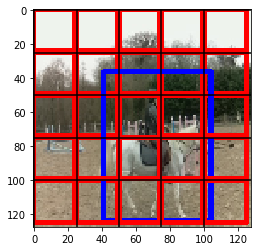

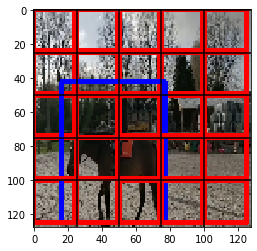

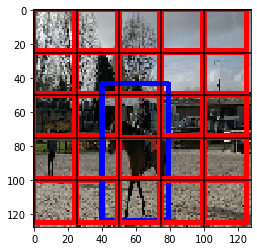

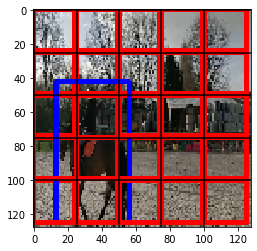

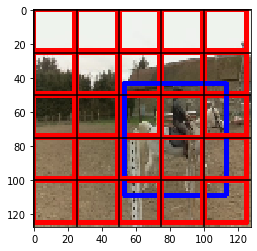

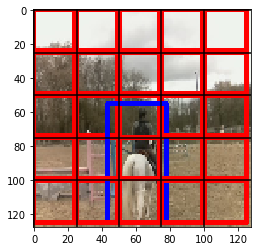

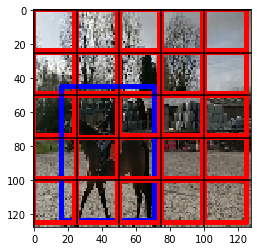

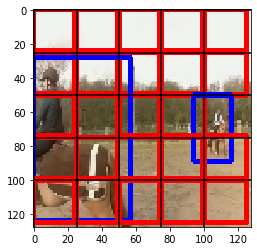

In [109]:
for batch in train_batches:
    for i in range(batch_size):
        img = (batch[0][i,] * 255).astype('uint8')
        for n, label in enumerate(batch[1][i,]):
            row = int(n / grid_h)
            col = n - (row * grid_w)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h) 
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cv2.rectangle(img, pt1, pt2, colors[np.argmax(label[:class_nb])], thickness=2)
        plt.figure()
        plt.imshow(img)
        for row in range(grid_w):
            plt.axvline(x=row*cell_w,color='black')
        for col in range(grid_h):
            plt.axhline(y=col*cell_h,color='black')
    break

In [110]:
def custom_loss(y_true, y_pred):

    y_true_class = y_true[...,0:class_nb]
    y_pred_class = y_pred[...,0:class_nb]

    pred_boxes = K.reshape(y_pred[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    true_boxes = K.reshape(y_true[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    
    y_pred_xy   = pred_boxes[...,0:2]
    y_pred_wh   = pred_boxes[...,2:4]
    y_pred_conf = pred_boxes[...,4]

    y_true_xy   = true_boxes[...,0:2]
    y_true_wh   = true_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # minimum distance between boxes distance between the two center
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)

    return clss_loss + xy_loss + wh_loss + conf_loss

In [111]:
K.clear_session()

img_in = Input(shape=(img_size[1], img_size[0], img_size[2]), name='img_in')

x = Conv2D(16, 1, padding='same')(img_in)
x = Conv2D(32, 3, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
#x = MaxPooling2D(2, 2)(x)

x = Conv2D(16, 1, padding='same')(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
#x = MaxPooling2D(2, 2)(x)

x = Conv2D(32, 1, padding='same')(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = Conv2D(64, 1, padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
#x = MaxPooling2D(2, 2)(x)

x = Conv2D(64, 1, padding='same')(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = Conv2D(128, 1, padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
#x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w * grid_h * (class_nb + nb_boxes * 5), activation='sigmoid')(x)
out = Reshape((grid_w * grid_h, (class_nb + nb_boxes * 5)))(x)

model = Model(inputs=img_in, outputs=out)

model.compile(optimizer = "adam", loss = custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        528       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640  

In [112]:
model_name = "model_horse_128.h5"
#save best model if model improved
best_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [113]:
idx = int(0.8*len(shuffled_dict_data))
train_data = {k: shuffled_dict_data[k] for k in list(shuffled_dict_data)[:idx]}
val_data = {k: shuffled_dict_data[k] for k in list(shuffled_dict_data)[idx:]}

train_batches = DataGenerator(train_data, data_path, class_nb, batch_size=batch_size, shuffle=True)
val_batches = DataGenerator(val_data, data_path, class_nb, batch_size=batch_size)

history = model.fit_generator(train_batches, validation_data = val_batches, epochs = 30, verbose=1, callbacks=[best_checkpoint])

Epoch 1/30
17/18 [===========================>..] - ETA: 0s - loss: 0.2042
Epoch 00001: val_loss improved from inf to 0.12367, saving model to model_horse_128.h5
18/18 [==============================] - 3s 185ms/step - loss: 0.1991 - val_loss: 0.1237
Epoch 2/30
17/18 [===========================>..] - ETA: 0s - loss: 0.1036
Epoch 00002: val_loss improved from 0.12367 to 0.10615, saving model to model_horse_128.h5
18/18 [==============================] - 3s 167ms/step - loss: 0.1025 - val_loss: 0.1062
Epoch 3/30
17/18 [===========================>..] - ETA: 0s - loss: 0.0924
Epoch 00003: val_loss improved from 0.10615 to 0.10211, saving model to model_horse_128.h5
18/18 [==============================] - 3s 168ms/step - loss: 0.0948 - val_loss: 0.1021
Epoch 4/30
17/18 [===========================>..] - ETA: 0s - loss: 0.0918
Epoch 00004: val_loss did not improve from 0.10211
18/18 [==============================] - 3s 175ms/step - loss: 0.0918 - val_loss: 0.1040
Epoch 5/30
17/18 [======

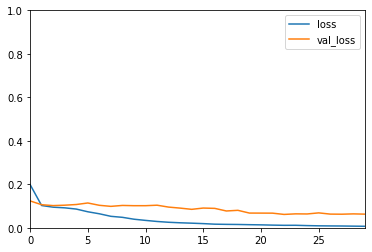

In [114]:
#print History graph
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,1))

In [115]:
# LOAD MODEL

from tensorflow.keras.models import load_model
from deepctr.layers import custom_objects

custom_objects["custom_loss"] = custom_loss
model = load_model(model_name, custom_objects=custom_objects)

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


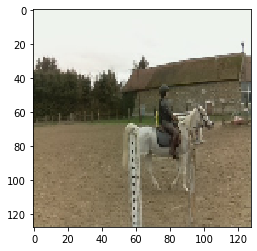

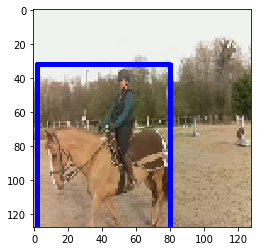

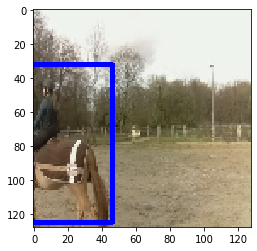

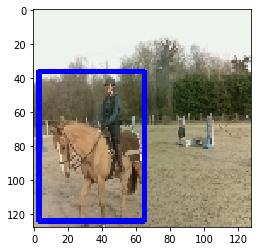

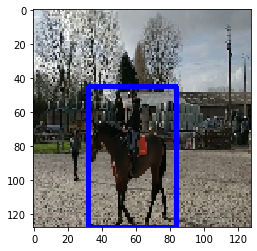

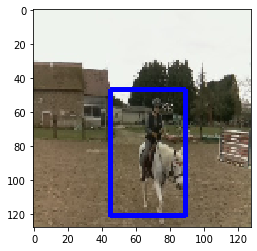

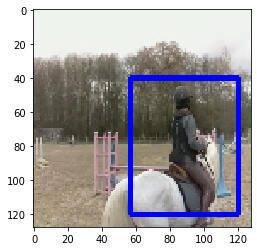

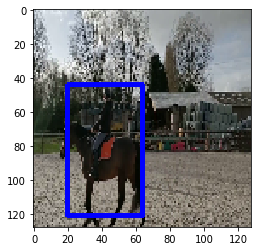

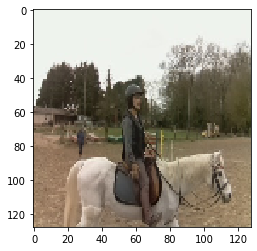

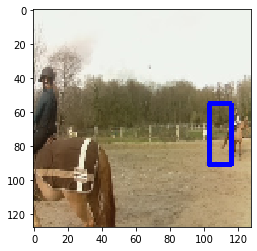

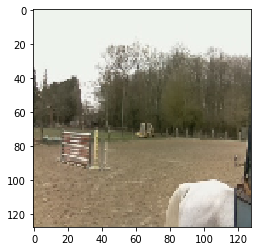

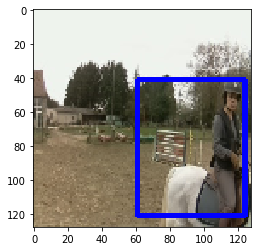

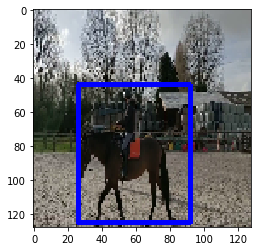

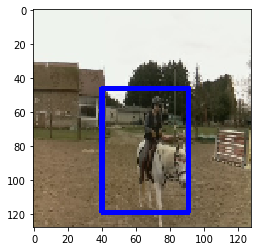

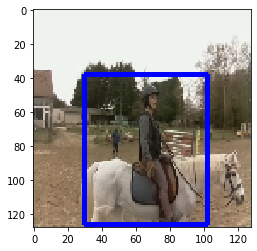

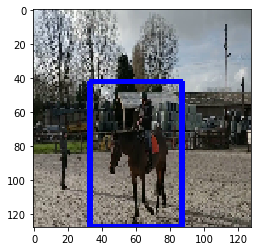

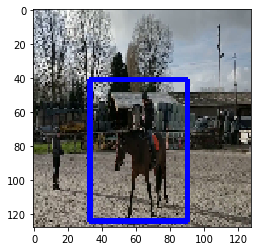

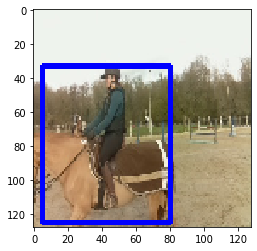

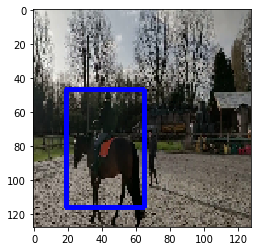

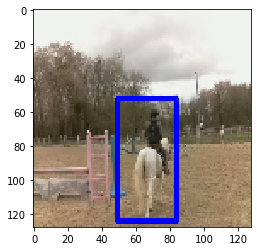

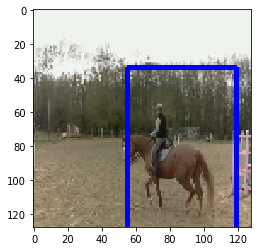

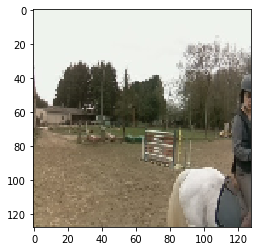

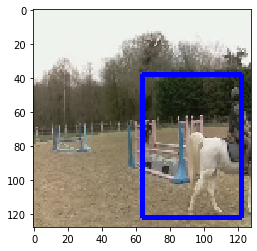

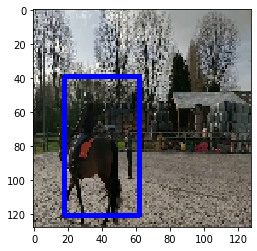

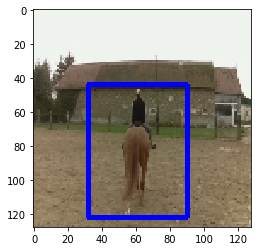

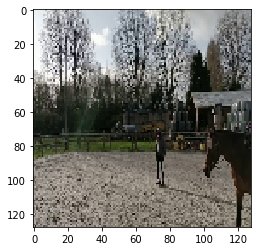

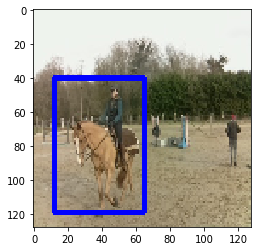

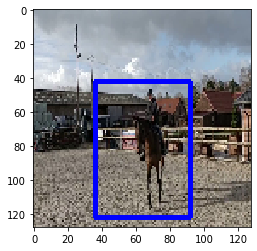

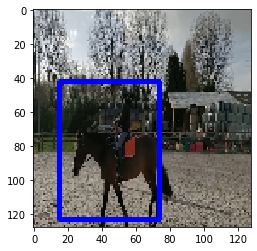

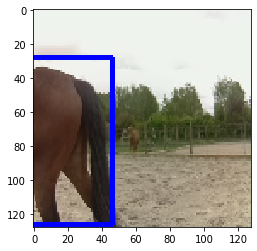

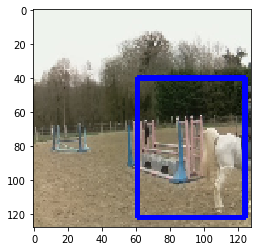

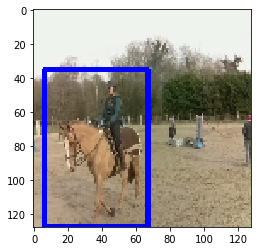

In [116]:
nb = 0
for batch in val_batches:
    nb += 1
    for i in range(batch_size):
        img = batch[0][i,]
        pred = model.predict(img.reshape((1, img_size[1], img_size[0], img_size[2])))
        img = (img * 255).astype('uint8')
        for n, label in enumerate(pred[0]):
            #print(label)
            row = int(n / grid_h)
            col = n - (row * grid_w)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h)
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cls = np.argmax(label[:class_nb])
            if cls > 0:
                cv2.rectangle(img, pt1, pt2, colors[cls], 2)
        plt.figure()
        plt.imshow(img)
    if nb > 4:
        break